## Get Data

In [1]:
import pandas as pd
import requests
import seaborn as sns
import re
from whatthelang import WhatTheLang
import jellyfish

In [2]:
URL = "https://keralarescue.in/data/"

In [4]:
df = pd.read_json(requests.get(URL).text)

In [5]:
df.head(2)

,dateadded,detailcloth,detailfood,detailkit_util,detailmed,detailrescue,detailtoilet,detailwater,district,id,...,needkit_util,needmed,needothers,needrescue,needtoilet,needwater,requestee,requestee_phone,status,supply_details
0,2018-08-16T09:17:58.895Z,,,,,,,,ekm,6765,...,False,False,Rescue from water filled house,False,False,False,Sreeram,094470581,new,
1,2018-08-16T09:21:22.609Z,,,,,,,,idk,6794,...,False,False,,False,False,False,Test,Test,new,


In [6]:
df.shape

(7684, 26)

In [7]:
df.columns

Index([u'dateadded', u'detailcloth', u'detailfood', u'detailkit_util',
       u'detailmed', u'detailrescue', u'detailtoilet', u'detailwater',
       u'district', u'id', u'is_request_for_others', u'latlng',
       u'latlng_accuracy', u'location', u'needcloth', u'needfood',
       u'needkit_util', u'needmed', u'needothers', u'needrescue',
       u'needtoilet', u'needwater', u'requestee', u'requestee_phone',
       u'status', u'supply_details'],
      dtype='object')

- We have the above columns available

## Distribution of requests  across districts

In [8]:
val_counts = df.district.value_counts()
val_counts

ekm    2976
ptm    1621
alp    1612
tcr    1263
idk      54
ktm      34
tvm      29
mpm      24
kol      23
koz      16
pkd      16
knr       6
wnd       5
ksr       5
Name: district, dtype: int64

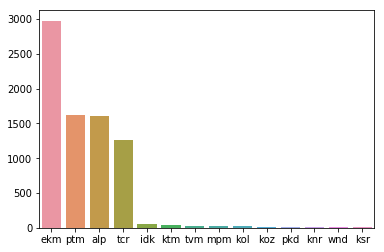

In [9]:
sns.barplot(x=val_counts.index, y=val_counts.values)

- As evident from the distribution ; **Ernakulam** (ekm), **Pathanamathitta** (ptm) , **Alappuzha** (alp) and **Thrissur** (tcr) 
  looks like the most affected districts.

In [10]:
df.shape

(7684, 26)

- We have at this point of time 7684 requests being made.

# Utility functions

In [11]:
PHONE_NUM_REGEX = "^(?:(?:\+|0{0,2})91(\s*[\-]\s*)?|[0]?)?[789]\d{9}$"
pattern = re.compile(PHONE_NUM_REGEX) 
lat_range = (8,10)
lng_range = (74,78)

In [12]:
def is_valid_num(ph_no): 
    return bool(re.match(pattern,ph_no)) 

In [13]:
def is_valid_kerala_lat_long(lat,lng):
    return 8 <= lat <= 9 and 74<= lng <=78


In [14]:
wtl = WhatTheLang()
def identify_lang(text): 
    try :
        return wtl.predict_lang(text)
    except ValueError:
        return "NA"
        

# Cleanup

In [15]:
print "Total Number of request is {}".format(df.shape[0])
print "Total Unique requests is {}".format(df.requestee_phone.unique().shape[0])

Total Number of request is 7684
Total Unique requests is 5833


- We have duplicates and should be removed. More discussion happened [here](https://github.com/IEEEKeralaSection/rescuekerala/issues/419) about this. 

In [16]:
cleaned_df = df.copy()

In [17]:
cleaned_df = cleaned_df.drop_duplicates(subset='requestee_phone')

In [18]:
print "Total requests after removing the duplicate phone numbers : {}".format(cleaned_df.shape[0])

Total requests after removing the duplicate phone numbers : 5833


In [19]:
cleaned_df["is_valid_phone"]= cleaned_df.apply(lambda x : is_valid_num(x["requestee_phone"]),axis =1)

In [20]:
cleaned_df.is_valid_phone.value_counts()

True     5466
False     367
Name: is_valid_phone, dtype: int64

In [21]:
cleaned_df = cleaned_df[cleaned_df.is_valid_phone]

In [22]:
print "Total requests after removing the invalid phone numbers : {}".format(cleaned_df.shape[0])

Total requests after removing the invalid phone numbers : 5466


In [23]:
cleaned_df["language"] = cleaned_df.apply(lambda x : identify_lang(x["location"]),axis =1)

In [24]:
cleaned_df_ml = cleaned_df[cleaned_df.language == "ml"]

In [25]:
print "Number of requests made in Malayalam is : {}. \
These need to be handled differently".format(cleaned_df_ml.shape[0])

Number of requests made in Malayalam is : 194. These need to be handled differently


In [26]:
cleaned_df = cleaned_df[cleaned_df.language != "ml"]

In [27]:
cleaned_df.location.value_counts()[:10]

Aluva              80
Chengannur         78
Chalakudy          61
Thiruvalla         52
Kalady             42
Poovathussery      36
Pandanad           33
chengannur         19
Ayroor             18
Thiruvanvandoor    16
Name: location, dtype: int64

- We can see that there are duplicates and typos in the location names. We need to handle basic typos.

In [28]:
cleaned_df["location"] = cleaned_df.location.apply(lambda x : x.lower())

In [29]:
cleaned_df.location.value_counts()[:200]

chengannur                                                109
aluva                                                      98
chalakudy                                                  71
thiruvalla                                                 63
kalady                                                     51
poovathussery                                              41
pandanad                                                   40
thiruvanvandoor                                            23
north paravur                                              21
chalakkudy                                                 19
ayroor                                                     19
chendamangalam                                             17
chenganoor                                                 16
niranam                                                    16
kongorpilly                                                16
kadukutty                                                  15
arattupu

- We can see that Chengannur is clearly one of the most affected. But can also see places mentioned as `chegannur` etc ; We can try to do use some distance metric to find the ones which are obvious typo

In [30]:
jellyfish.jaro_distance(u"chengannur",u"chegannur")

0.9296296296296296

- Jaro distance seems to be a good metric here. We can try to find the closest matching string to the 
below locations (top 15)
       u'chengannur', u'aluva', u'chalakudy', u'thiruvalla', u'kalady',
       u'poovathussery', u'pandanad', u'thiruvanvandoor', u'north paravur',
       u'chalakkudy', u'ayroor', u'chendamangalam', u'niranam', u'kadukutty',
       u'arattupuzha'

In [31]:
all_location = cleaned_df.location.unique().tolist()

In [32]:
top_15_loc = cleaned_df.location.value_counts()[:15].index.tolist()
top_15_loc

[u'chengannur',
 u'aluva',
 u'chalakudy',
 u'thiruvalla',
 u'kalady',
 u'poovathussery',
 u'pandanad',
 u'thiruvanvandoor',
 u'north paravur',
 u'chalakkudy',
 u'ayroor',
 u'chendamangalam',
 u'chenganoor',
 u'niranam',
 u'kongorpilly']

In [33]:
def build_mapping(all_location,top_15_loc):
    loc_mapping = {}
    for loc in all_location:
        for tloc in top_15_loc:
            max_dist = 0
            if loc == tloc:
                continue
            else:
                sim = jellyfish.jaro_distance(loc,tloc)
                if sim > 0.85 and sim > loc_mapping.get("loc",0):
                    loc_mapping[loc] = tloc
    return loc_mapping

In [34]:
loc_mapping = build_mapping(all_location,top_15_loc)
loc_mapping

{u'aliva': u'aluva',
 u'aluva,': u'aluva',
 u'ayiroor': u'ayroor',
 u'chalakka': u'chalakkudy',
 u'chalakkkudy': u'chalakkudy',
 u'chalakkudi': u'chalakkudy',
 u'chalakkudy': u'chalakudy',
 u'chalakkudy south': u'chalakkudy',
 u'chalakuddy': u'chalakkudy',
 u'chalakudi': u'chalakkudy',
 u'chalakudy': u'chalakkudy',
 u'chalakudy meloor': u'chalakudy',
 u'chalakudy north': u'chalakudy',
 u'chalakudy,meloor': u'chalakudy',
 u'chegannur': u'chenganoor',
 u'cheganoor': u'chenganoor',
 u'chenagnnur': u'chengannur',
 u'chendamangalam panchayath': u'chendamangalam',
 u'chendamangalam paravur': u'chendamangalam',
 u'chendamangalam, paravoor': u'chendamangalam',
 u'chendamangalam, paravur': u'chendamangalam',
 u'chengamanad': u'chendamangalam',
 u'chengannoor': u'chenganoor',
 u'chengannor': u'chenganoor',
 u'chengannur': u'chenganoor',
 u'chengannur edakavu': u'chengannur',
 u'chengannur, othara': u'chengannur',
 u'chengannur- ala': u'chengannur',
 u'chengannuur': u'chengannur',
 u'chenganoor':

- Mapping Looks good. We will map these locations also to the top 15 locations

In [36]:
def map_location(location): return loc_mapping.get(location,location)

In [40]:
cleaned_df["new_location"] = cleaned_df.apply(lambda x : map_location(x["location"]),axis =1)

In [41]:
cleaned_df.new_location.value_counts()[:20]

chenganoor           141
aluva                100
chalakkudy            96
thiruvalla            72
kalady                60
pandanad              57
poovathussery         53
thiruvanvandoor       43
north paravur         34
chalakudy             29
chendamangalam        26
ayroor                24
chengannur            23
kongorpilly           21
niranam               17
kadukutty             15
arattupuzha           15
parakkadavu           14
east kadungalloor     14
aranmula              14
Name: new_location, dtype: int64

- This is the Top 20 affected locations along with number of requests

In [57]:
cleaned_df[(cleaned_df.new_location.isin(["chenganoor","chengannur","pandanad"]))][["requestee","detailrescue","location","requestee_phone"]].to_csv("chengannur_rescuee_needs.csv",index=False,encoding="utf8")